<h2> 3.6 Featurizing text data with tfidf weighted word-vectors </h2>

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import time
import warnings
import numpy as np
from nltk.corpus import stopwords
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
warnings.filterwarnings("ignore")
import sys
import os 
import pandas as pd
import numpy as np
from tqdm import tqdm



In [2]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)


id1='1gTfCTD3fz-3NJnfYLm59nZFN3WC3fzfD'
downloaded1 = drive.CreateFile({'id': id1})
downloaded1.GetContentFile('df_fe_without_preprocessing_train.csv')

id2='1JncN1Fyt-ND_yZXOzqEfcRsYMTKqtu7Q'
downloaded1 = drive.CreateFile({'id': id2})
downloaded1.GetContentFile('nlp_features_train.csv')

  
id3='10QDGTSI5PEV9e7CTpfzsXRpUwRIsJA-J'
downloaded1 = drive.CreateFile({'id': id3})
downloaded1.GetContentFile('train.csv')

     |████████████████████████████████| 993kB 45.3MB/s eta 0:00:01


In [ ]:
# avoid decoding problems
df = pd.read_csv("train.csv")
from sklearn.model_selection import train_test_split
# merge texts
df_train,df_test=train_test_split(df,test_size=0.2)

# encode questions to unicode
# https://stackoverflow.com/a/6812069
# ----------------- python 2 ---------------------
# df['question1'] = df['question1'].apply(lambda x: unicode(str(x),"utf-8"))
# df['question2'] = df['question2'].apply(lambda x: unicode(str(x),"utf-8"))
# ----------------- python 3 ---------------------
df_train['question1'] = df_train['question1'].apply(lambda x: str(x))
df_train['question2'] = df_train['question2'].apply(lambda x: str(x))

df_test['question1'] = df_test['question1'].apply(lambda x: str(x))
df_test['question2'] = df_test['question2'].apply(lambda x: str(x))

In [4]:
df.head(2)

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
# merge texts
questions = list(df_train['question1']) + list(df_train['question2'])

tfidf = TfidfVectorizer(lowercase=False, )
tfidf.fit_transform(questions)

# dict key:word and value:tf-idf score
word2tfidf = dict(zip(tfidf.get_feature_names(), tfidf.idf_))

- After we find TF-IDF scores, we convert each question to a weighted average of word2vec vectors by these scores.
- here we use a pre-trained GLOVE model which comes free with "Spacy".  https://spacy.io/usage/vectors-similarity
- It is trained on Wikipedia and therefore, it is stronger in terms of word semantics. 

In [6]:
# en_vectors_web_lg, which includes over 1 million unique vectors.
nlp = spacy.load('en_core_web_sm')

vecs1 = []
# https://github.com/noamraph/tqdm
# tqdm is used to print the progress bar
for qu1 in tqdm(list(df_train['question1'])):
    doc1 = nlp(qu1) 
    # 96 is the number of dimensions of vectors 
    mean_vec1 = np.zeros([len(doc1), len(doc1[0].vector)])
    for word1 in doc1:
        # word2vec
        vec1 = word1.vector
        # fetch df score
        try:
            tfidf = word2tfidf[str(word1)] * (qu1.count(str(word1))/len(qu1.split()))
        except:
            tfidf = 0
        # compute final vec
        mean_vec1 += vec1 * tfidf
    mean_vec1 = mean_vec1.mean(axis=0)
    vecs1.append(mean_vec1)
df_train['q1_feats_m'] = list(vecs1)


100%|██████████| 323432/323432 [43:06<00:00, 125.03it/s]


In [ ]:
df_train.to_csv('mid1.csv')
df_test.to_csv('test.csv')

In [11]:
vecs2 = []
from tqdm import tqdm
for qu2 in tqdm(list(df_train['question2'])):
    doc2 = nlp(qu2) 
    mean_vec2 = np.zeros([len(doc2), len(doc2[0].vector)])
    for word2 in doc2:
        # word2vec
        vec2 = word2.vector
        # fetch df score

        try:
            
            tfidf = word2tfidf[str(word2)] * (qu2.count(str(word2))/len(qu2.split()))
        except:
            #print word
            tfidf = 0
        # compute final vec
        
        #print(tfidf)
        mean_vec2 += vec2 * tfidf
    mean_vec2 = mean_vec2.mean(axis=0)
    
    vecs2.append(mean_vec2)
df_train['q2_feats_m'] = list(vecs2)


100%|██████████| 323432/323432 [41:04<00:00, 131.24it/s]


In [12]:
#Test Features Questions1 and Questions2
# en_vectors_web_lg, which includes over 1 million unique vectors.
nlp = spacy.load('en_core_web_sm')

vecs1 = []
# https://github.com/noamraph/tqdm
# tqdm is used to print the progress bar
for qu1 in tqdm(list(df_test['question1'])):
    doc1 = nlp(qu1) 
    # 384 is the number of dimensions of vectors 
    mean_vec1 = np.zeros([len(doc1), len(doc1[0].vector)])
    for word1 in doc1:
        # word2vec
        vec1 = word1.vector
        # fetch df score
        try:
            tfidf = word2tfidf[str(word1)] * (qu1.count(str(word1))/len(qu1.split()))
        except:
            tfidf = 0
        # compute final vec
        mean_vec1 += vec1 * tfidf
    mean_vec1 = mean_vec1.mean(axis=0)
    vecs1.append(mean_vec1)
df_test['q1_feats_m'] = list(vecs1)

########################################

vecs2 = []
for qu2 in tqdm(list(df_test['question2'])):
    doc2 = nlp(qu2) 
    mean_vec2 = np.zeros([len(doc2), len(doc2[0].vector)])
    for word2 in doc2:
        # word2vec
        vec2 = word2.vector
        # fetch df score
        try:
            tfidf = word2tfidf[str(word2)] * (qu2.count(str(word2))/len(qu2.split()))
        except:
            #print word
            tfidf = 0
        # compute final vec
        mean_vec2 += vec2 * tfidf
    mean_vec2 = mean_vec2.mean(axis=0)
    vecs2.append(mean_vec2)
df_test['q2_feats_m'] = list(vecs2)

100%|██████████| 80858/80858 [10:07<00:00, 133.04it/s]


In [13]:
df_train.head(2)

,id,qid1,qid2,question1,question2,is_duplicate,q1_feats_m,q2_feats_m
287851,287851,408683,408684,What are some examples of terrestrial animals?,What are terrestrial animals? What are example...,1,"[9.50959499180317, -2.984976351261139, -11.809...","[4.78945130109787, -5.7303591668605804, -9.730..."
172952,172952,266924,266925,Why is ASEAN one of the most peaceful and pros...,Why and how did Lebanon become the most peacef...,0,"[0.6344003081321716, -1.813245631987229, -12.8...","[-7.4249771372415125, -6.347789332270622, -11...."


In [ ]:
#prepro_features_train.csv (Simple Preprocessing Feartures)
#nlp_features_train.csv (NLP Features)
if os.path.isfile('nlp_features_train.csv'):
    dfnlp = pd.read_csv("nlp_features_train.csv",encoding='latin-1')
else:
    print("download nlp_features_train.csv from drive or run previous notebook")

if os.path.isfile('df_fe_without_preprocessing_train.csv'):
    dfppro = pd.read_csv("df_fe_without_preprocessing_train.csv",encoding='latin-1')
else:
    print("download df_fe_without_preprocessing_train.csv from drive or run previous notebook")

In [ ]:
df1 = dfnlp.drop(['qid1','qid2','question1','question2'],axis=1)
df2 = dfppro.drop(['qid1','qid2','question1','question2','is_duplicate'],axis=1)


df3_train = df_train.drop(['qid1','qid2','question1','question2','is_duplicate'],axis=1)
df3_test = df_test.drop(['qid1','qid2','question1','question2','is_duplicate'],axis=1)

df3_q1_train = pd.DataFrame(df3_train.q1_feats_m.values.tolist(), index= df3_train.index)
df3_q2_train = pd.DataFrame(df3_train.q2_feats_m.values.tolist(), index= df3_train.index)

df3_q1_test = pd.DataFrame(df3_test.q1_feats_m.values.tolist(), index= df3_test.index)
df3_q2_test = pd.DataFrame(df3_test.q2_feats_m.values.tolist(), index= df3_test.index)

In [ ]:
# dataframe of nlp features
df1.head()

,id,is_duplicate,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,token_set_ratio,token_sort_ratio,fuzz_ratio,fuzz_partial_ratio,longest_substr_ratio
0,0,0,0.999980,0.833319,0.999983,0.999983,0.916659,0.785709,0.0,1.0,2.0,13.0,100,93,93,100,0.982759
1,1,0,0.799984,0.399996,0.749981,0.599988,0.699993,0.466664,0.0,1.0,5.0,12.5,86,63,66,75,0.596154
2,2,0,0.399992,0.333328,0.399992,0.249997,0.399996,0.285712,0.0,1.0,4.0,12.0,66,66,54,54,0.166667
3,3,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,2.0,12.0,36,36,35,40,0.039216
4,4,0,0.399992,0.199998,0.999950,0.666644,0.571420,0.307690,0.0,1.0,6.0,10.0,67,47,46,56,0.175000


In [ ]:
# data before preprocessing 
df2.head()

,id,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,freq_q1+q2,freq_q1-q2
0,0,1,1,66,57,14,12,10.0,23.0,0.434783,2,0
1,1,4,1,51,88,8,13,4.0,20.0,0.200000,5,3
2,2,1,1,73,59,14,10,4.0,24.0,0.166667,2,0
3,3,1,1,50,65,11,9,0.0,19.0,0.000000,2,0
4,4,3,1,76,39,13,7,2.0,20.0,0.100000,4,2


In [16]:
# Questions 1 tfidf weighted word2vec
df3_q1_train.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95
287851,9.509595,-2.984976,-11.809498,-9.398076,3.067511,8.801890,18.589524,13.412171,-8.947324,3.094738,1.691513,8.095941,-6.303056,-0.427843,-7.003376,-0.748968,4.154996,-2.291023,8.080150,8.278644,-6.462129,-0.737898,-0.235452,4.537895,4.017996,7.173647,1.704798,1.237732,10.924204,5.328782,2.646659,-6.434639,-7.008202,-6.083318,6.618583,2.543236,-5.672268,10.457816,-8.264491,18.614475,...,-11.419065,1.236458,-5.794618,-1.939053,-4.704448,-2.556173,15.138295,-7.257904,-4.743637,9.749738,-1.817478,3.658660,-7.542569,-3.279955,-3.166110,-0.905803,5.192864,-0.364392,7.728776,1.199033,12.618125,-9.968715,-6.569936,-4.077975,-10.841807,-14.701773,-5.615776,14.994381,0.695577,-4.842362,3.442499,1.640088,6.817366,3.112806,-1.793013,3.135360,-3.560157,1.866096,-4.823692,-0.425846
172952,0.634400,-1.813246,-12.816122,-12.080643,5.457196,6.322567,15.836552,13.633682,0.312183,8.396769,0.150165,7.360641,-5.962791,-7.630841,-5.020401,3.522857,2.372590,7.632984,3.762090,8.595857,-7.852826,-9.295640,4.023685,13.181084,5.077215,7.039378,7.549188,-0.501529,4.046289,17.695318,7.906723,-6.016496,-8.967220,-2.282251,7.592375,6.390906,-1.614485,5.990179,-10.741943,10.547681,...,-0.509952,6.118096,-11.951702,-3.893855,-1.671958,-4.216384,1.241491,-2.646215,-3.549613,6.363665,-1.073801,-8.755880,-10.410566,-10.266473,2.105469,8.306117,3.856037,3.997876,3.283546,-2.170684,12.741116,-12.991741,-6.143995,-8.938692,-8.198422,-6.042458,-4.802310,8.049190,-5.368274,6.490154,9.402603,2.374286,0.734876,2.210260,3.313199,3.587876,-9.266031,3.471059,2.444621,1.979798
247768,4.431505,-4.361650,-14.430818,-18.104730,-2.806155,6.768903,9.910724,4.264563,-0.473978,10.360899,-4.802288,-1.079249,-19.055429,-3.026365,-3.590284,-2.060192,-1.798055,6.740497,4.999477,8.722835,-3.349558,-5.820761,8.355772,6.227257,8.459014,2.607435,8.793812,-2.773101,-0.665938,15.091018,12.850567,-9.745835,-1.240837,-0.605949,7.560911,-1.937670,2.289374,9.414200,-3.008853,1.216820,...,-2.822593,-3.240056,-6.264749,9.042799,-4.246354,-4.030239,15.877108,-2.235856,-4.093766,9.954416,-2.260144,10.709959,-3.060452,9.768427,4.333365,-5.513066,13.107864,8.112344,13.303394,8.201615,0.741760,-2.043699,-10.131824,-2.633367,-1.452103,-12.734809,-13.799173,1.847137,0.229086,-5.043510,0.072122,-14.750861,6.186821,2.483959,-2.532530,2.819104,-2.395037,-0.371811,3.454752,3.053820
97009,8.108846,-5.319327,-6.192122,-12.733797,-1.011927,4.555990,10.343346,8.802996,-1.492674,6.124089,-2.084184,3.179069,-8.062579,-4.078246,-0.651208,-0.236969,4.904613,7.411832,5.864543,13.814109,-5.158693,-2.385786,3.346305,5.559901,-0.018484,6.021548,4.847834,0.826688,4.814593,8.900593,5.123895,0.077174,-2.587443,-1.389524,7.737603,2.125724,-3.245216,3.797454,1.114827,1.629650,...,-3.875933,4.878070,-6.997631,-2.860798,-0.978205,-0.364062,4.940702,-0.610198,-1.695569,7.536193,2.099060,4.564160,-5.394021,-2.568257,-2.209078,3.138192,0.509038,2.391164,2.291351,-1.185645,1.614205,-1.758273,-0.517461,1.757455,-5.846789,-7.959715,-10.782722,0.479260,-0.932473,-1.343219,2.279865,-0.225354,-4.746208,4.460910,0.462583,0.581240,-1.711343,1.485384,0.710626,-2.989335
223297,3.949012,-6.848152,-4.856686,-11.317435,-9.334562,1.511885,7.551820,10.383319,0.304397,9.664529,-6.060358,3.826666,-12.001611,-3.521086,2.266071,-2.369269,-1.272218,8.547030,13.582911,9.554670,-11.676729,-9.466930,11.451459,15.707175,-1.336251,1.359192,8.459381,-3.768732,-2.797023,10.526479,1.379260,-2.551673,-9.958905,-3.325168,2.606976,5.285274,4.382398,6.705949,-3.569291,2.256525,...,-3.333005,-0.860082,-8.353470,3.883584,-1.972722,-5.209264,-1.742294,1.514132,-9.639716,7.633890,5.878526,0.721881,-8.058714,4.210082,-0.268413,-5.413268,1.458112,11.203975,4.849625,11.447165,-1.641866,-0.832450,1.123999,-5.456777,-4.471026,-0.007

In [17]:
df3_q1_test.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95
157561,25.026054,-12.854203,-9.678908,-11.264161,-10.215891,-2.118202,31.566062,5.966860,-6.212604,12.947480,-4.721270,-6.075376,-8.535069,-16.209612,-1.013473,-2.965789,16.058956,11.943741,0.017544,10.845661,-12.055827,-15.683305,9.624656,21.081420,-1.351233,-1.717200,11.987191,-12.667363,0.222950,34.281001,14.108251,4.945513,-4.849025,3.119186,13.476799,-1.176014,-17.232893,15.477876,1.626920,-2.543411,...,3.739769,-3.639188,-12.637721,2.332421,-12.133846,-2.304493,16.770844,-4.494542,-1.388609,16.372948,10.158867,5.490551,-7.762344,7.778493,-9.578330,-6.224568,-1.165697,20.776454,0.088872,17.565869,0.539370,-8.259760,-10.242416,-15.399972,-3.899840,-8.201684,-17.783960,12.739991,-5.722935,0.636866,6.719412,-0.219325,12.030707,1.111896,3.915992,-9.138846,3.601260,-1.824206,-4.753558,7.415056
55473,3.153236,-9.807701,-4.287981,-10.497754,-5.162055,-4.743260,8.219638,2.725274,0.194639,8.444565,-8.259800,8.336918,-18.307568,3.545547,3.067420,-6.419003,11.556953,5.623813,9.577541,8.728185,-4.954347,-11.130281,8.916562,22.158957,-2.558591,5.251475,9.028775,-4.468414,2.849426,13.956688,3.050223,-9.898802,-6.226555,-6.535197,9.464583,0.503888,-2.923849,9.747632,3.044790,8.853636,...,-1.648263,-2.173418,-8.906834,0.579249,-8.044167,-6.576378,3.401646,1.723407,-9.300610,5.142695,6.977218,-1.098502,-7.410183,5.390485,4.047209,1.405818,6.973583,9.660406,8.529007,10.165295,3.022903,-8.904441,-3.226240,-5.012496,-1.124405,-2.878430,-7.709710,-2.355510,0.939109,-1.312647,7.843023,-4.867048,0.990400,6.969420,-0.948179,0.996781,-6.203502,1.911023,-2.651912,7.959680
58292,26.724261,-34.266608,-16.617415,-27.571456,-6.003354,5.019149,37.134820,13.056351,-15.587229,10.477277,2.765593,-14.594760,-7.860152,-24.994246,-18.802183,-12.016078,11.023600,29.320579,5.573961,28.354035,-19.603802,-14.745078,16.760176,31.883778,-15.563741,11.420548,1.538563,-20.740651,25.146940,40.070135,14.423905,-6.719687,-8.774575,-2.743660,26.832397,12.438938,-15.364844,9.559419,-1.773282,4.129486,...,8.978238,18.197583,-19.215146,-8.049232,-25.784281,22.559807,11.870551,4.348325,-11.609832,46.608410,0.164725,-15.373382,-2.142098,-8.943905,8.642553,14.615098,-13.177623,6.820156,-4.908731,2.981052,-4.649168,-16.732299,-3.984409,-29.297677,-23.371328,-14.268071,-18.879427,11.568874,8.576639,5.542166,21.837860,12.528985,7.359051,8.883575,10.581327,4.699246,-33.923656,1.174232,-17.885525,15.088691
124205,5.418724,-5.579635,-5.298835,-6.650882,-0.867129,2.277497,4.982583,14.247606,-7.309681,6.909354,-3.446842,-7.683994,-5.293639,-16.219441,-6.043888,1.211198,5.572096,6.957943,-5.052719,2.048629,-13.010932,-16.437561,16.343671,12.064842,-5.592797,-2.958274,1.391542,-2.258689,-1.658594,21.625799,2.594576,-0.417195,0.748362,5.162182,5.109074,3.174784,-4.425768,11.004832,10.252584,-7.471720,...,6.385204,0.045094,-14.788554,-1.442861,-7.546309,7.724198,5.200766,-1.504384,-5.170331,9.495537,6.647026,-1.193621,-5.480157,-3.688828,0.229512,2.551094,-7.200671,11.410437,-0.975199,9.962537,-4.054538,-4.443706,-0.263081,-5.218626,-3.661550,-4.962313,-15.658082,0.065376,3.870829,0.336733,8.675623,5.248007,7.049481,7.740102,12.570964,-1.202226,5.209290,3.629717,0.565035,2.699225
211135,-0.915871,-4.670748,-7.094173,-7.577088,-2.944890,4.100913,15.464195,8.516277,3.587404,1.071980,2.100014,5.814831,-8.225620,-2.280331,8.220332,-4.874116,5.708084,-0.164656,3.167801,7.425088,-10.760129,-7.883744,10.523446,14.110472,0.158759,5.130409,6.765922,-11.911552,5.810382,9.816580,7.550865,-0.436815,-0.959671,-1.466861,8.063568,4.092882,-0.198780,8.694429,-1.899203,6.387929,...,-4.338168,-0.300005,-6.616566,-2.006314,-7.489709,-1.194568,0.150251,-7.649520,-3.309443,3.574505,4.160130,-3.219686,-8.375205,-0.047999,0.913080,-1.544992,9.609333,16.978956,7.009932,1.852150,0.

In [ ]:
print("Number of features in nlp dataframe :", df1.shape[1])
print("Number of features in preprocessed dataframe :", df2.shape[1])
print("Number of features in question1 w2v  dataframe :", df3_q1.shape[1])
print("Number of features in question2 w2v  dataframe :", df3_q2.shape[1])
print("Number of features in final dataframe  :", df1.shape[1]+df2.shape[1]+df3_q1.shape[1]+df3_q2.shape[1])

In [ ]:
# storing the final features to csv file
if not os.path.isfile('final_features.csv'):
    df3_q1_train['id']=df_train['id']
    df3_q2_train['id']=df_train['id']
    
    df3_q1_test['id']=df_test['id']
    df3_q2_test['id']=df_test['id']
    
    df1  = df1.merge(df2, on='id',how='inner')
    
    df2_train  = df3_q1_train.merge(df3_q2_train, on='id',how='inner')
    df2_test   = df3_q1_test.merge(df3_q2_test, on='id',how='inner')
    
    result_train  = df1.merge(df2_train, on='id',how='inner')
    result_test  = df1.merge(df2_test, on='id',how='inner')
    
    
    result_train.to_csv('final_features_train.csv')
    result_test.to_csv('final_features_test.csv')

In [19]:
result_test.shape,result_train.shape

((80858, 220), (323432, 220))

<h3> XGBoost on TFIDF Weighted W2V on Questions

In [1]:
!wget --header="Host: doc-00-58-docs.googleusercontent.com" --header="User-Agent: Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/76.0.3809.100 Safari/537.36" --header="Accept: text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3" --header="Accept-Language: en-GB,en-US;q=0.9,en;q=0.8" --header="Referer: https://drive.google.com/drive/u/0/search?q=final_features_train.csv" --header="Cookie: AUTH_f79jrck61g36irfb06hiu34q4b401ieh=15923203954827925545|1565712000000|d97djekb9lmp9b90ntp4mn07qecbf4ub; _ga=GA1.2.1518331858.1560046699; NID=188=X_j5gZPQThhpMXzcQZW3ApzuX7j7tcWuSNfLk6HAhP4Z2qOb1ikhBgWppNK8wIFLZQN4AYCwVqeeJtlkQhtwpQbdRzP_iIDD5G_mnS4Ma2ZUCmGavezZ4Uj8s5I9uY7OxL0h0VLkireAEXtOJrXFFY5c-bFoqzaBbYligxKWvao" --header="Connection: keep-alive" "https://doc-00-58-docs.googleusercontent.com/docs/securesc/qgbh6kjdsd98f3gihp270udf3ooq8huc/72qp0q01ae1bdm21jllpmu1i3u8nh8fa/1565719200000/15923203954827925545/15923203954827925545/1NE36Qhqn27kUkhKpra_P2f3-tXsYl9xG?e=download" -O "final_features_train.csv" -c

--2019-08-13 19:14:42--  https://doc-00-58-docs.googleusercontent.com/docs/securesc/qgbh6kjdsd98f3gihp270udf3ooq8huc/72qp0q01ae1bdm21jllpmu1i3u8nh8fa/1565719200000/15923203954827925545/15923203954827925545/1NE36Qhqn27kUkhKpra_P2f3-tXsYl9xG?e=download
Resolving doc-00-58-docs.googleusercontent.com (doc-00-58-docs.googleusercontent.com)... 74.125.197.132, 2607:f8b0:400e:c03::84
Connecting to doc-00-58-docs.googleusercontent.com (doc-00-58-docs.googleusercontent.com)|74.125.197.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/csv]
Saving to: ‘final_features_train.csv’

final_features_trai     [     <=>            ]   1.16G   160MB/s    in 8.9s    

2019-08-13 19:14:51 (133 MB/s) - ‘final_features_train.csv’ saved [1244544516]



In [2]:
!wget --header="Host: doc-08-58-docs.googleusercontent.com" --header="User-Agent: Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/76.0.3809.100 Safari/537.36" --header="Accept: text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3" --header="Accept-Language: en-GB,en-US;q=0.9,en;q=0.8" --header="Referer: https://drive.google.com/drive/u/0/search?q=final_features_test.csv" --header="Cookie: AUTH_f79jrck61g36irfb06hiu34q4b401ieh=15923203954827925545|1565712000000|d97djekb9lmp9b90ntp4mn07qecbf4ub; _ga=GA1.2.1518331858.1560046699; NID=188=X_j5gZPQThhpMXzcQZW3ApzuX7j7tcWuSNfLk6HAhP4Z2qOb1ikhBgWppNK8wIFLZQN4AYCwVqeeJtlkQhtwpQbdRzP_iIDD5G_mnS4Ma2ZUCmGavezZ4Uj8s5I9uY7OxL0h0VLkireAEXtOJrXFFY5c-bFoqzaBbYligxKWvao" --header="Connection: keep-alive" "https://doc-08-58-docs.googleusercontent.com/docs/securesc/qgbh6kjdsd98f3gihp270udf3ooq8huc/3f4htdnq5pk7ck92fiukbahq2efnmbdj/1565719200000/15923203954827925545/15923203954827925545/11kPWHuyFUvomF-vwmkkIiKXryZNfXJIY?e=download" -O "final_features_test.csv" -c

--2019-08-13 19:15:20--  https://doc-08-58-docs.googleusercontent.com/docs/securesc/qgbh6kjdsd98f3gihp270udf3ooq8huc/3f4htdnq5pk7ck92fiukbahq2efnmbdj/1565719200000/15923203954827925545/15923203954827925545/11kPWHuyFUvomF-vwmkkIiKXryZNfXJIY?e=download
Resolving doc-08-58-docs.googleusercontent.com (doc-08-58-docs.googleusercontent.com)... 74.125.197.132, 2607:f8b0:400e:c03::84
Connecting to doc-08-58-docs.googleusercontent.com (doc-08-58-docs.googleusercontent.com)|74.125.197.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/csv]
Saving to: ‘final_features_test.csv’

final_features_test     [           <=>      ] 296.67M   103MB/s    in 2.9s    

2019-08-13 19:15:23 (103 MB/s) - ‘final_features_test.csv’ saved [311078704]



In [5]:
result_train=pd.read_csv('final_features_train.csv')
result_test=pd.read_csv('final_features_test.csv')

In [6]:
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV

y_train=result_train['is_duplicate']
y_test=result_test['is_duplicate']
X_tr=result_train.drop(['is_duplicate'],axis=1)
X_te=result_test.drop(['is_duplicate'],axis=1)


x_cfl=xgb.XGBClassifier()

prams = {
    'learning_rate':[0.01,0.1,0.2],
     'n_estimators':[100,500,1000],
     'max_depth':[3,5,8],
    'colsample_bytree':[0.1,0.5,1],
    'subsample':[0.1,0.5,1]
}
random_cfl1=RandomizedSearchCV(x_cfl,param_distributions=prams,scoring='neg_log_loss',cv=2,verbose=1,n_jobs=-1)
random_cfl1.fit(X_tr,y_train)

Fitting 2 folds for each of 10 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed: 104.6min finished


RandomizedSearchCV(cv=2, error_score='raise-deprecating',
                   estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                           colsample_bylevel=1,
                                           colsample_bynode=1,
                                           colsample_bytree=1, gamma=0,
                                           learning_rate=0.1, max_delta_step=0,
                                           max_depth=3, min_child_weight=1,
                                           missing=None, n_estimators=100,
                                           n_jobs=1, nthread=None,
                                           objective='binary:logistic',
                                           random_state=0, reg_alpha=0,
                                           reg_lambda=1, scale_pos_weight=1,
                                           seed=None, silent=None, subsample=1,
                                           verbosity=1),
          

In [ ]:
import shutil
import os
source = os.listdir("/content")
destination = "/content/drive/My Drive"
for files in source:
    if files.endswith(".csv"):
        shutil.copy(files,destination)

In [7]:
print (random_cfl1.best_params_)

{'subsample': 0.1, 'n_estimators': 500, 'colsample_bytree': 0.1, 'max_depth': 5, 'learning_rate': 0.01}


In [8]:
from sklearn.calibration import CalibratedClassifierCV

cfl=xgb.XGBClassifier(n_estimators=500,subsample=0.1,learning_rate=0.01,colsample_bytree=0.1,max_depth=5)
cfl.fit(X_tr,y_train)
c_cfl=CalibratedClassifierCV(x_cfl,method='sigmoid')
c_cfl.fit(X_tr,y_train)

predict_y = c_cfl.predict_proba(X_tr)

In [11]:

print ('train loss',log_loss(y_train, predict_y))
predict_y = c_cfl.predict_proba(X_te)
print ('test loss',log_loss(y_test, predict_y))

train loss 0.39909822481038637
test loss 0.40790524897003333


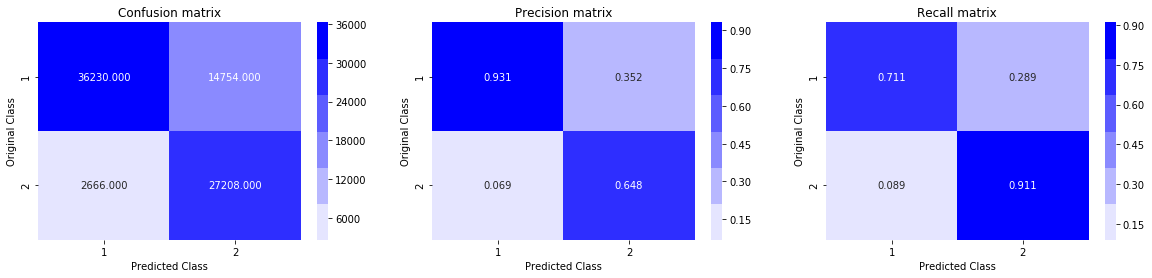

In [14]:
#y_test = list(map(int, y_test.values))
from sklearn.metrics import confusion_matrix
import seaborn as sns
predicted_y =np.array(predict_y>0.5,dtype=int)
plot_confusion_matrix(y_test, predicted_y[:,1])

In [10]:
# This function plots the confusion matrices given y_i, y_i_hat.
from sklearn.metrics import log_loss
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    # C = 9,9 matrix, each cell (i,j) represents number of points of class i are predicted class j
    
    A =(((C.T)/(C.sum(axis=1))).T)
    #divid each element of the confusion matrix with the sum of elements in that column
    
    # C = [[1, 2],
    #     [3, 4]]
    # C.T = [[1, 3],
    #        [2, 4]]
    # C.sum(axis = 1)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =1) = [[3, 7]]
    # ((C.T)/(C.sum(axis=1))) = [[1/3, 3/7]
    #                           [2/3, 4/7]]

    # ((C.T)/(C.sum(axis=1))).T = [[1/3, 2/3]
    #                           [3/7, 4/7]]
    # sum of row elements = 1
    
    B =(C/C.sum(axis=0))
    #divid each element of the confusion matrix with the sum of elements in that row
    # C = [[1, 2],
    #     [3, 4]]
    # C.sum(axis = 0)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =0) = [[4, 6]]
    # (C/C.sum(axis=0)) = [[1/4, 2/6],
    #                      [3/4, 4/6]] 
    plt.figure(figsize=(20,4))
    
    labels = [1,2]
    # representing A in heatmap format
    cmap=sns.light_palette("blue")
    plt.subplot(1, 3, 1)
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")
    
    plt.subplot(1, 3, 2)
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precision matrix")
    
    plt.subplot(1, 3, 3)
    # representing B in heatmap format
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Recall matrix")
    
    plt.show()

<h1> Conclusion

So the Train Logloss is 0.39909822481038637 <br>
and the Test Logloss 0.40790524897003333